# Image bounding-boxes
The metadata for the BelgaLogos dataset provides the locations of the logo bounding boxes in the corresponding images.
Here I study the properties of these bounding boxes, and attempt to load the image patches described by them.
We'll start by reading in the metadata, and computing some statistics on bounding-box dimensions for the whole dataset.

In [1]:
import pandas as pd
import lib.load_data as ld
import lib.util as ut

# Load the data annotations
md = ld.read_metadata()
ut.compute_bb_properties(md).describe()

,Width,Height,Area
count,9844.000000,9844.000000,9844.000000
mean,34.443925,32.690167,2222.433259
std,81.082587,37.699059,14143.708552
min,-742.000000,-455.000000,-180276.000000
25%,21.000000,17.000000,377.000000
50%,31.000000,24.000000,756.000000
75%,50.000000,37.000000,1716.000000
max,748.000000,977.000000,642866.000000


We already have some clear problems. Firstly the dataset is supposed to contain only images smaller than 800 pixels (in either width or height) and these stats show a maximum *bounding box* height of 977. All bounding-boxes are also supposed to be at a minimum 10px by 10px in size. However there is a clearly anomalous **negative** minimum bounding-box size. This is most likely due to the 'top-left' and 'bottom-right' coordinates being swapped.

Let's see if things improve when we move filter out all the 'junk' annotations by selecting only those for which the 'ok' flag is True.

In [2]:
ok_data = md[md.ok == True]
ut.compute_bb_properties(ok_data).describe()

,Width,Height,Area
count,2697.00000,2697.000000,2697.000000
mean,66.74898,48.874676,5196.541342
std,80.22164,53.276843,22674.118349
min,-690.00000,-380.000000,-180276.000000
25%,38.00000,26.000000,1056.000000
50%,57.00000,36.000000,1980.000000
75%,91.00000,55.000000,4355.000000
max,748.00000,977.000000,642866.000000


Even without the junk annotations, we still have problems. We could play with the dataset to tidy it up, but as time is short, let's play it safe and setup a function in `load_data.py` that filters out:

1. All bounding-boxes with width or height > max_dim (800px).
2. All bounding-boxes with width or height < min_dim (10px).

In [3]:
filtered_data = ld.filter_by_boundingbox(ok_data, 10, 800)
ut.compute_bb_properties(filtered_data).describe()

,Width,Height,Area
count,2639.000000,2639.000000,2639.000000
mean,73.199697,48.366806,5287.103827
std,56.159896,45.482432,17323.949977
min,14.000000,11.000000,176.000000
25%,39.000000,26.000000,1096.000000
50%,57.000000,36.000000,2021.000000
75%,92.000000,55.000000,4449.000000
max,748.000000,623.000000,376292.000000


Much better! Now with the crude filtering, all bounding-boxes are at least *superficially* within expected limits.
The count (number of images remaining after filtering) has also not dropped much. However we still need to be aware of further potential issues with the annotation (misplaced bounding boxes, wrong labelling etc).

## Bounding-Box properties
Let's first look at the basic statistics of this filtered dataset in some more detail, by plotting histograms of the bounding box areas, heights and widths.

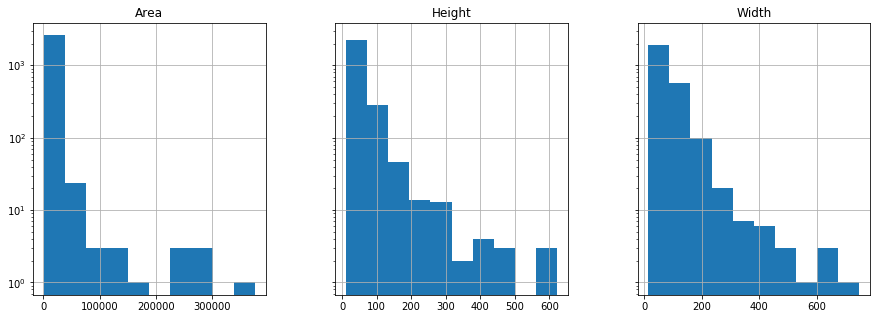

In [6]:
filtered_stats = ut.compute_bb_properties(filtered_data)
fig = filtered_stats.hist(sharey=True, layout = (1,3), log=True, figsize=(15,5))

**Note the logarithmic y-axis.**

Looking at these histograms, we can see a sharp drop-off of the number of images with area (and correspondingly height/width). So should we need to filter the dataset more aggressively (e.g to reduce computational load) this should be achievable.

## Test extraction of bounding-box images

Let's now check that these bounding-box coordinates actually correspond to logo bounding-boxes! As a start, let's look at the Peugeot images:

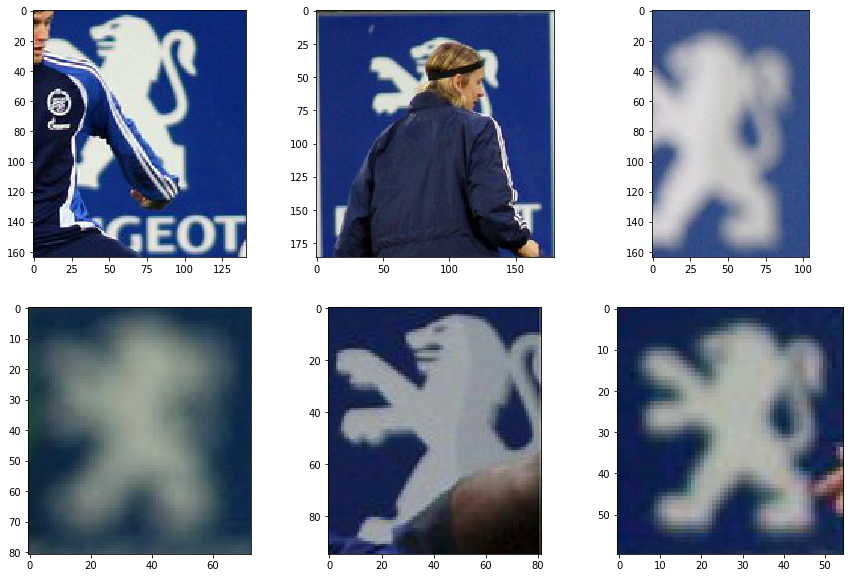

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Get only Peugeot logos and images
peugeot_data = filtered_data[filtered_data.brand == 'Peugeot']
peugeot_images = ld.load_bb_images(peugeot_data)

# Setup plot (assuming 6 figures here)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = np.ndarray.flatten(axes)

# Plot images
images = peugeot_images.values.tolist()
for ax, im in zip(axes, images):
    ax.imshow(im)

The bounding-box information therefore seems to be succesfully parsed. Although the quality of the images is not very high, with large parts of the logo being obscured in some images, and poor focus/resolution in others. Some of these images are likely to prove challenging for a logo-identification system.